<a href="https://colab.research.google.com/github/Bhavana0929/LSTM_from_scratch/blob/main/LSTM_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
from numpy import ndarray
from typing import Dict, List, Tuple
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from IPython import display
from copy import deepcopy
from collections import deque

In [17]:
def sigmoid(x: ndarray):
    return 1 / (1 + np.exp(-x))

In [18]:
def dsigmoid (x: ndarray):
    return sigmoid(x) * (1 - sigmoid(x))

In [19]:
def tanh (x: ndarray):
    return np.tanh(x)

In [20]:
def dtanh (x: ndarray):
    return 1 - np.tanh(x) * np.tanh(x)

In [21]:
def softmax (x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))

def batch_softmax (input_array: ndarray):
    out = []
    for row in input_array:
        out.append(softmax(row, axis=1))

    return np.stack(out)

In [22]:
class LSTMOptimizer (object):
    def __init__(self, lr = 0.01, gradient_clipping = True):
        self.lr= lr
        self.gradient_clipping = gradient_clipping
        self.first = True

    def step(self):
        for layer in self.model.layers:
            for key in layer.params.keys():

                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])

                self._update_rule(param=layer.params[key]['value'], grad=layer.params[key]['deriv'])

    def _update_rule (self, **kwargs):
        raise NotImplementedError()

In [23]:
class SGD(LSTMOptimizer):
    def __init__(self, lr=0.01, gradient_clipping=True):
        super().__init__(lr, gradient_clipping)

    def _update_rule(self, **kwargs):
        update = self.lr*kwargs['grad']
        kwargs['param'] -= update

In [24]:
class AdaGrad (LSTMOptimizer):
    def __init__(self, lr=0.01, gradient_clipping=True):
        super().__init__(lr, gradient_clipping)
        self.eps = 1e-7

    def step(self):
        if self.first:
            self.sum_squares = {}
            for i, layer in enumerate(self.model.layers):
                self.sum_squares[i] = {}
                for key in layer.params.keys():
                    self.sum_squares[i][key] = np.zeros_like(layer.params[key]['value'])
            self.first = False

            for i, layer in enumerate(self.model.layers):
                for key in layer.params.keys():
                    if self.gradient_clipping:
                        np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['value'])

                    self._update_rule(param=layer.params[key]['value'], grad=layer.params[key]['deriv'], sum_square=self.sum_squares[i][key])

    def _update_rule(self, **kwargs):
        kwargs['sum_square'] += (self.eps + np.power(kwargs['grad'], 2))

        lr = np.divide(self.lr, np.sqrt(kwargs['sum_square']))

        kwargs['param'] -= lr * kwargs['grad']

In [25]:
class Loss(object):
    def __init__(self):
        pass

    def forward(self, prediction, target):
        self.prediction = prediction
        self.target = target

        self.output = self._output()

        return self.output

    def backward (self):
        self.input_grad = self._input_grad()

        return self.input_grad

    def _output(self):
        raise NotImplementedError()

    def _input_grad(self):
        raise NotImplementedError()

In [26]:
class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.eps = eps
        self.single_class = False

    def _output (self):
        out = []

        for row in self.prediction:
            out.append(softmax(row, axis=1))

        softmax_preds = np.stack(out)

        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        softmax_cross_entropy_loss = -1.0 * self.target * np.log(self.softmax_preds) - (1.0 - self.target) * np.log(1 - softmax_preds)

        return np.sum(softmax_cross_entropy_loss)

    def _input_grad(self):
        return self.softmax_preds - self.target

**LSTM Architecture :**
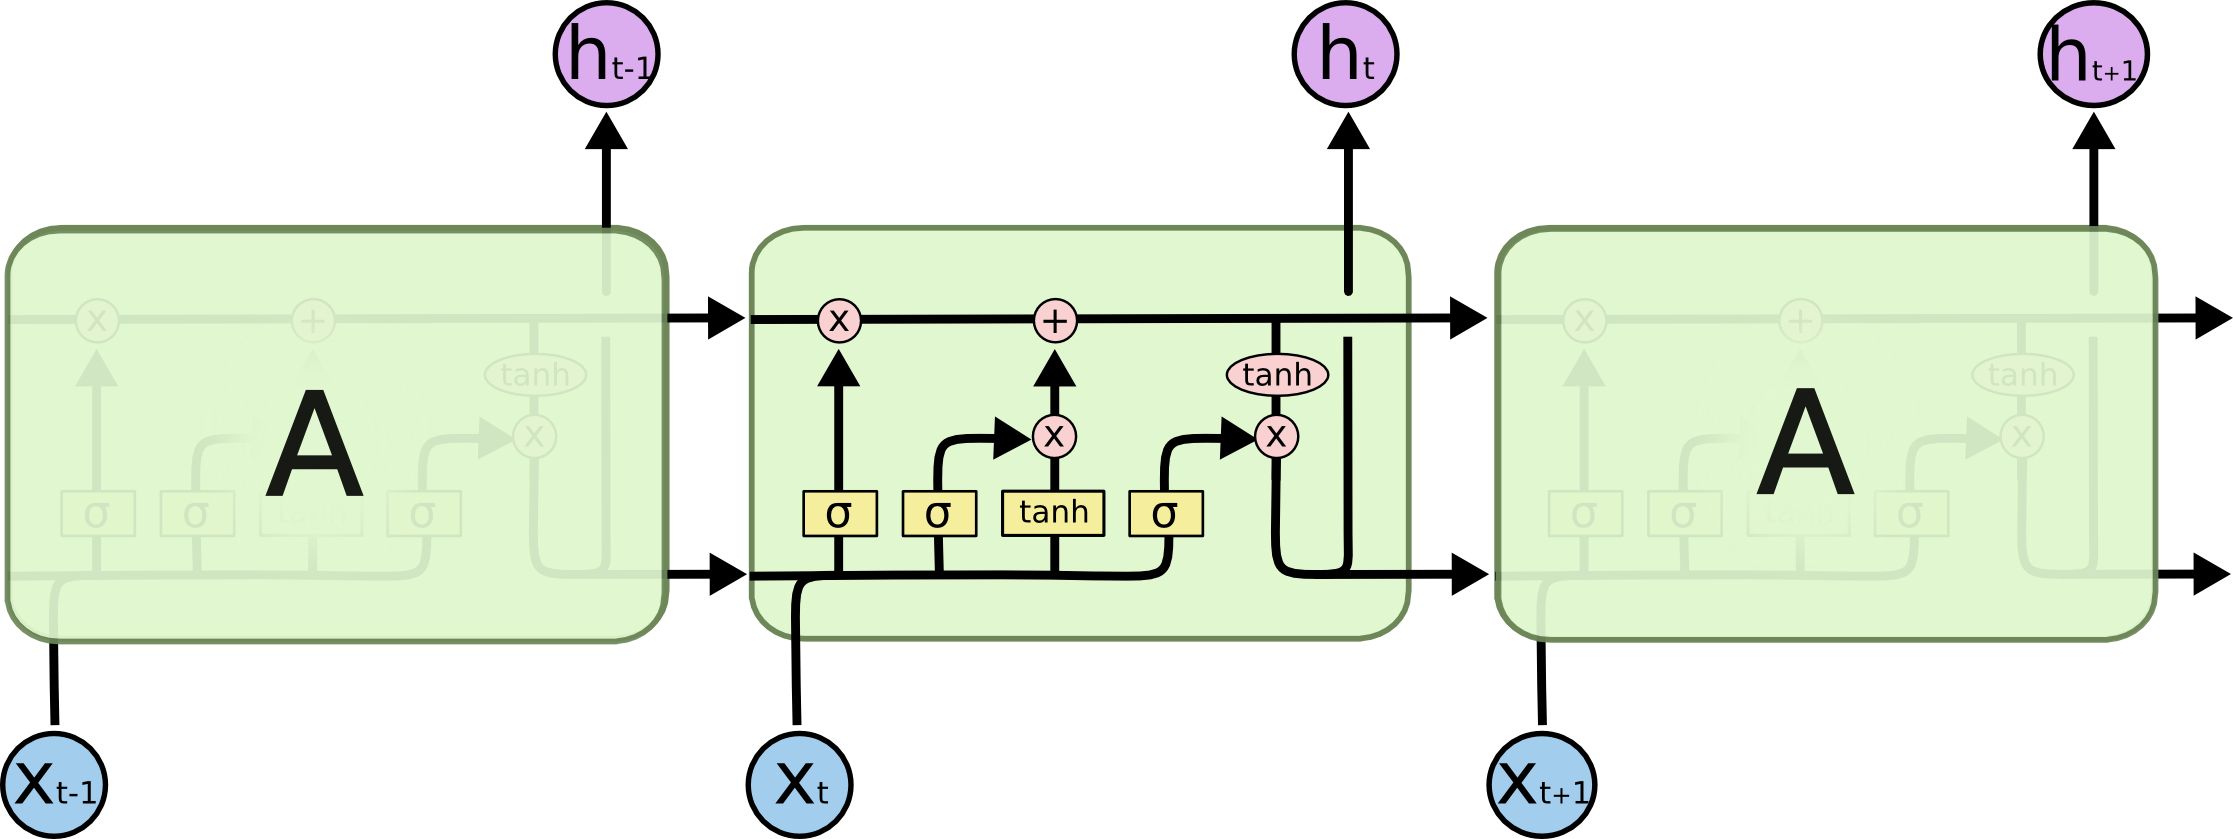

**LSTM NODE :**

In [27]:
class LSTMNode:
    def __init__(self):
        pass

    def forward (self, X_in, H_in, C_in, params_dict):
        self.X_in = X_in
        self.C_in = C_in

        self.Z = np.column_stack((X_in, C_in))

        self.f_int = np.dot(self.Z, params_dict['W_f']['value'] + params_dict['B_f']['value'])

        self.f = sigmoid(self.f_int)

        self.i_int = np.dot(self.Z, params_dict['W_i']['value'] + params_dict['B_i']['value'])

        self.i = sigmoid(self.i_int)

        self.C_bar_int = np.dot(self.Z, params_dict['W_c']['value'] + params_dict['B_c']['value'])

        self.C_bar = tanh(self.C_bar_int)

        self.C_out = self.f * C_in + self.i * self.C_bar
        self.o_int = np.dot(self.Z, params_dict['W_o']['value'] + params_dict['B_o']['value'])

        self.o = sigmoid(self.o_int)

        self.H_out = self.o * tanh (self.C_out)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']

        return self.X_out, self.H_out, self.C_out

    def backward(self,
                 X_out_grad: ndarray,
                 H_out_grad: ndarray,
                 C_out_grad: ndarray,
                 params_dict: Dict[str, Dict[str, ndarray]]):
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)
        dh_out += H_out_grad

        do = dh_out * tanh(self.C_out)
        do_int = dsigmoid(self.o_int) * do
        params_dict['W_o']['deriv'] += np.dot(self.Z.T, do_int)
        params_dict['B_o']['deriv'] += do_int.sum(axis=0)

        dC_out = dh_out * self.o * dtanh(self.C_out)
        dC_out += C_out_grad
        dC_bar = dC_out * self.i
        dC_bar_int = dtanh(self.C_bar_int) * dC_bar
        params_dict['W_c']['deriv'] += np.dot(self.Z.T, dC_bar_int)
        params_dict['B_c']['deriv'] += dC_bar_int.sum(axis=0)

        di = dC_out * self.C_bar
        di_int = dsigmoid(self.i_int) * di
        params_dict['W_i']['deriv'] += np.dot(self.Z.T, di_int)
        params_dict['B_i']['deriv'] += di_int.sum(axis=0)

        df = dC_out * self.C_in
        df_int = dsigmoid(self.f_int) * df
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, df_int)
        params_dict['B_f']['deriv'] += df_int.sum(axis=0)

        dz = (np.dot(df_int, params_dict['W_f']['value'].T)
             + np.dot(di_int, params_dict['W_i']['value'].T)
             + np.dot(dC_bar_int, params_dict['W_c']['value'].T)
             + np.dot(do_int, params_dict['W_o']['value'].T))

        dx_prev = dz[:, :self.X_in.shape[1]]
        dH_prev = dz[:, self.X_in.shape[1]:]
        dC_prev = self.f * dC_out

        return dx_prev, dH_prev, dC_prev


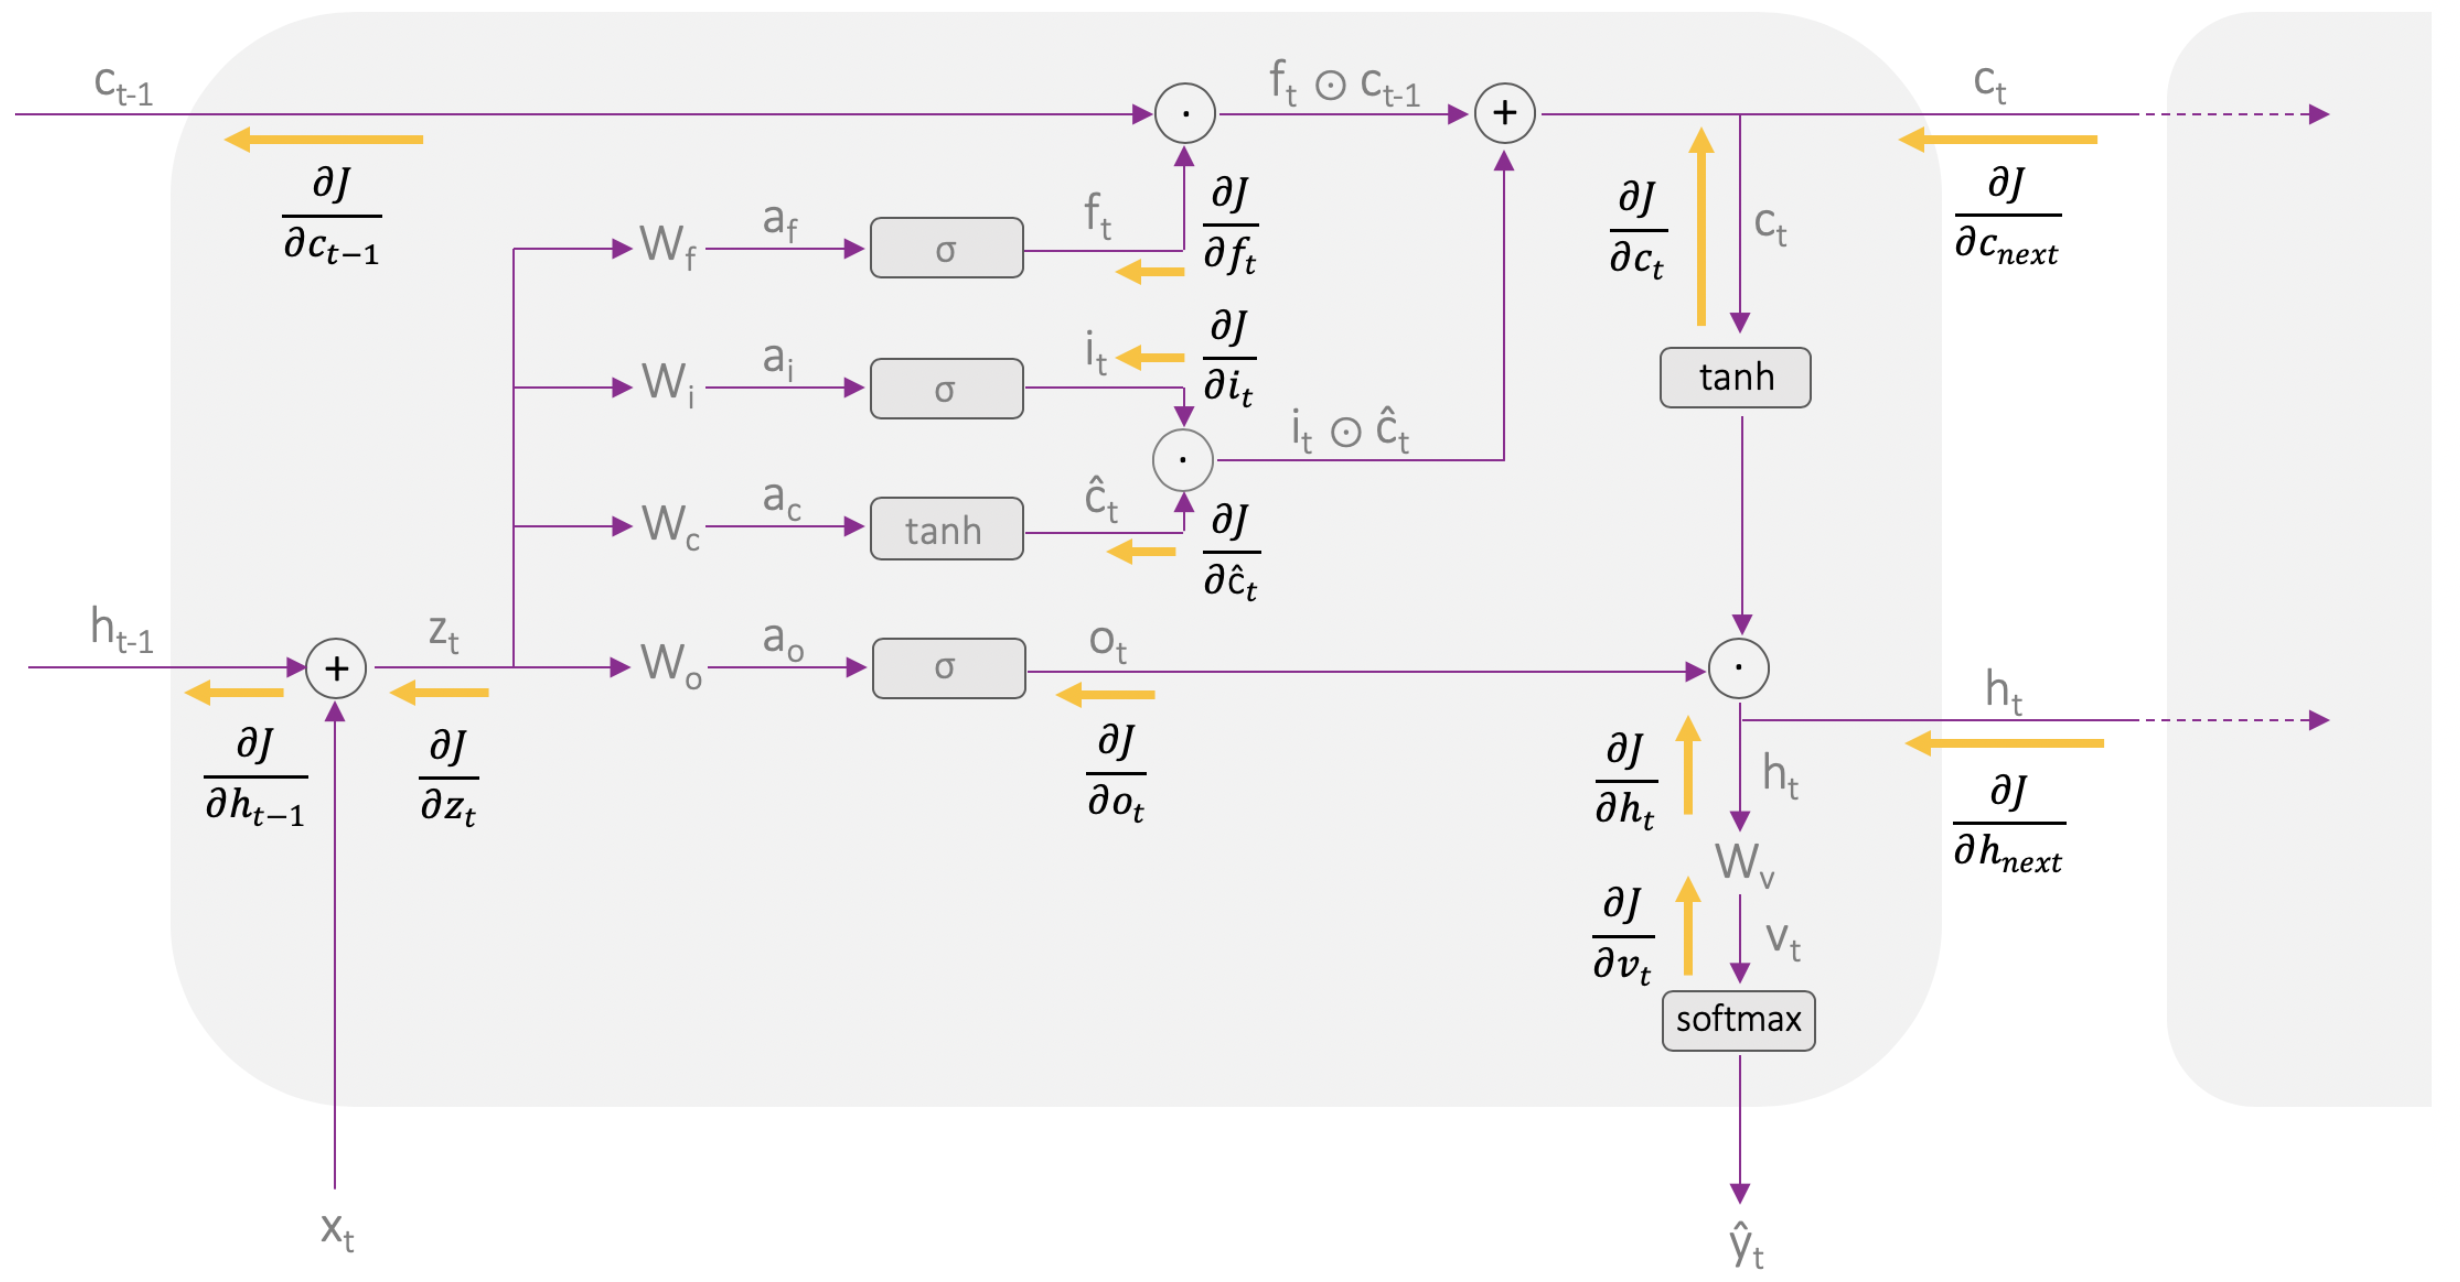

**LSTM LAYER :**

In [28]:
class LSTMLayer:
    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = 0.01):
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.start_C = np.zeros((1, hidden_size))
        self.first = True


    def _init_params(self,
                     input_: ndarray):

        self.vocab_size = input_.shape[2]

        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_i'] = {}
        self.params['B_i'] = {}
        self.params['W_c'] = {}
        self.params['B_c'] = {}
        self.params['W_o'] = {}
        self.params['B_o'] = {}
        self.params['W_v'] = {}
        self.params['B_v'] = {}

        self.params['W_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size =(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(1, self.hidden_size))
        self.params['W_i']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_i']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))

        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])

        self.cells = [LSTMNode() for x in range(input_.shape[1])]


    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])

    def forward(self, x_seq_in: ndarray):
        if self.first:
            self._init_params(x_seq_in)
            self.first=False

        batch_size = x_seq_in.shape[0]

        H_in = np.copy(self.start_H)
        C_in = np.copy(self.start_C)

        H_in = np.repeat(H_in, batch_size, axis=0)
        C_in = np.repeat(C_in, batch_size, axis=0)

        sequence_length = x_seq_in.shape[1]

        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))

        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]

            y_out, H_in, C_in = self.cells[t].forward(x_in, H_in, C_in, self.params)

            x_seq_out[:, t, :] = y_out

        self.start_H = H_in.mean(axis=0, keepdims=True)
        self.start_C = C_in.mean(axis=0, keepdims=True)

        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        batch_size = x_seq_out_grad.shape[0]

        h_in_grad = np.zeros((batch_size, self.hidden_size))
        c_in_grad = np.zeros((batch_size, self.hidden_size))

        num_chars = x_seq_out_grad.shape[1]

        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))

        for t in reversed(range(num_chars)):

            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad, c_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)

            x_seq_in_grad[:, t, :] = grad_out

        return x_seq_in_grad

In [29]:
class LSTMModel(object):
    def __init__(self,
                 layers: List[LSTMLayer],
                 sequence_length: int,
                 vocab_size: int,
                 hidden_size: int,
                 loss: Loss):
        self.layers = layers
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.loss = loss
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)


    def forward(self,
                x_batch: ndarray):
        for layer in self.layers:

            x_batch = layer.forward(x_batch)

        return x_batch

    def backward(self,
                 loss_grad: ndarray):

        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)

        return loss_grad

    def single_step(self,
                    x_batch: ndarray,
                    y_batch: ndarray):

        x_batch_out = self.forward(x_batch)

        loss = self.loss.forward(x_batch_out, y_batch)
        print(loss)

        loss_grad = self.loss.backward()

        for layer in self.layers:
            layer._clear_gradients()

        self.backward(loss_grad)
        return loss

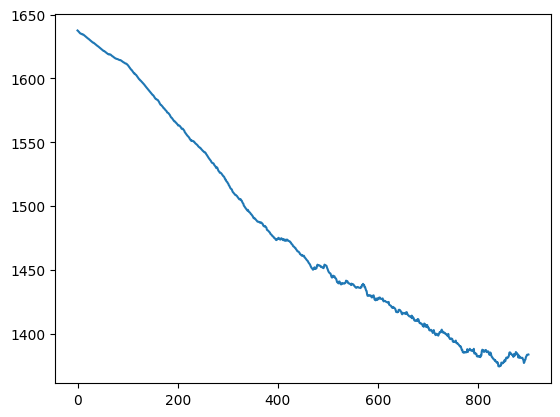

i,odhe,zow'rD  zuYwGcnmhMdG
she;s.lnih.tiueywsw.F eymu tzzYSe
fd   . !qeu  l bdtcu bR ff 
dR ScAocuItO fymu-oA ohriallnll cat.PsItSbc
urheSdhqom   WearagdG srhmd 
yt?
cmtkhaeNt B,hcYnmPsshdoI. hfyTTDr
1599.0196728049023
1578.9747375858165
1378.441161702519
1347.7165204368944
1519.4604690410638
1346.9554683955755
1392.7031499713921
1354.748903307681
1535.6682191171199
1359.073027658374
1609.9580129956855
1490.417575014645
1298.9786156716832
1317.7394490892252
1374.2280407754347
1507.018922138031
1502.2579660685758
1405.418111632874
1392.2964016920873
1535.2936480497397
1357.0703503685315
1305.510473297218
1689.699533804575
1355.458463250143
1328.9634168522127
1376.1808049735305
1307.2558768795682
1363.7153591839133
1547.8970310195884
1345.2887466387256
1301.198043667971
1461.8917048157732
1382.6152540369817
1356.921254183646
1310.7666957102415
1402.1393389234272
1615.5329479950915
1314.3034888543418
1595.724904355245
1535.2589214607192
1321.2763471133346
1424.469494940113
1344.794865562

In [30]:
class LSTMTrainer:
    def __init__(self,
                 text_file: str,
                 model: LSTMModel,
                 optim: LSTMOptimizer,
                 batch_size: int = 32):
        self.data = open(text_file, 'r').read()
        self.model = model
        self.chars = list(set(self.data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
        self.sequence_length = self.model.sequence_length
        self.batch_size = batch_size
        self.optim = optim
        setattr(self.optim, 'model', self.model)


    def _generate_inputs_targets(self,
                                 start_pos: int):

        inputs_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        targets_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)

        for i in range(self.batch_size):

            inputs_indices[i, :] = np.array([self.char_to_idx[ch]
                            for ch in self.data[start_pos + i: start_pos + self.sequence_length  + i]])
            targets_indices[i, :] = np.array([self.char_to_idx[ch]
                         for ch in self.data[start_pos + 1 + i: start_pos + self.sequence_length + 1 + i]])

        return inputs_indices, targets_indices


    def _generate_one_hot_array(self,
                                indices: ndarray):
        batch = []
        for seq in indices:

            one_hot_sequence = np.zeros((self.sequence_length, self.vocab_size))

            for i in range(self.sequence_length):
                one_hot_sequence[i, seq[i]] = 1.0

            batch.append(one_hot_sequence)

        return np.stack(batch)


    def sample_output(self,
                      input_char: int,
                      sample_length: int):
        indices = []

        sample_model = deepcopy(self.model)

        for i in range(sample_length):
            input_char_batch = np.zeros((1, 1, self.vocab_size))

            input_char_batch[0, 0, input_char] = 1.0

            x_batch_out = sample_model.forward(input_char_batch)

            x_softmax = batch_softmax(x_batch_out)

            input_char = np.random.choice(range(self.vocab_size), p=x_softmax.ravel())

            indices.append(input_char)

        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt

    def train(self,
              num_iterations: int,
              sample_every: int=100):
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))

        num_iter = 0
        start_pos = 0

        moving_average = deque(maxlen=100)
        while num_iter < num_iterations:

            if start_pos + self.sequence_length + self.batch_size + 1 > len(self.data):
                start_pos = 0

            inputs_indices, targets_indices = self._generate_inputs_targets(start_pos)

            inputs_batch, targets_batch = \
                self._generate_one_hot_array(inputs_indices), self._generate_one_hot_array(targets_indices)

            loss = self.model.single_step(inputs_batch, targets_batch)
            self.optim.step()

            moving_average.append(loss)
            ma_loss = np.mean(moving_average)

            start_pos += self.batch_size

            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [ma_loss])

            if num_iter % 100 == 0:
                plt.plot(plot_iter, plot_loss)
                display.clear_output(wait=True)
                plt.show()

                sample_text = self.sample_output(self.char_to_idx[self.data[start_pos]],
                                                 200)
                print(sample_text)

            num_iter += 1


layers = [LSTMLayer(hidden_size=256, output_size=62), LSTMLayer(hidden_size=256, output_size=62)]
mod = LSTMModel(layers=layers,
               vocab_size=62, sequence_length=10,
               loss=SoftmaxCrossEntropy(), hidden_size=256)
optim = SGD(lr=0.001, gradient_clipping=True)
trainer = LSTMTrainer('input.txt', mod, optim)
trainer.train(1000, sample_every=100)

In [35]:
# Choose a starting character and sample length
start_char = 'B'  # Example starting character
sample_length = 5  # Number of characters to generate

# Convert the starting character to its corresponding index
start_char_idx = trainer.char_to_idx[start_char]

# Generate text using the sample_output method
generated_text = trainer.sample_output(start_char_idx, sample_length)

# Display the generated text
print(generated_text)

sVBon
